# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
from nltk.corpus import stopwords

import pickle
from datetime import datetime
from time import time

import numpy as np
import pandas as pd
import re
from nltk.stem.wordnet import WordNetLemmatizer
from sqlalchemy import create_engine
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve

from sklearn.neighbors import KNeighborsClassifier
from workspace_utils import active_session

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
def load_messages(database, table_name):
    engine = create_engine('sqlite:///'+database)
    df = pd.read_sql_table(table_name, engine, index_col='index')
    X = df['message']
    y = df.drop(columns=['id', 'message'])
    return X, y, y.columns.values

### 2. Write a tokenization function to process your text data

In [3]:
stopwords_english = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
lemmatize = lemmatizer.lemmatize

def tokenize_word(text):
    
    # Replace urls
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, "url_placeholder", text)
    
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = nltk.word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatize(word) for word in tokens if word not in stopwords_english]

    return tokens

### 3. Build a machine learning pipeline

This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [4]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.multioutput import MultiOutputClassifier

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier


from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [5]:
def flat_pipeline(clf):
    return Pipeline([
        ('counts', CountVectorizer(tokenizer=tokenize_word)),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])


### 3.1 Define the classifiers

In [6]:
classifiers = [# KNeighborsClassifier(n_neighbors=20),
               # MLPClassifier(),
               # ExtraTreesClassifier(),
               # RandomForestClassifier(n_estimators=150),
                 MultiOutputClassifier(LogisticRegression()),
                 MultiOutputClassifier(AdaBoostClassifier()),
                 MultiOutputClassifier(DecisionTreeClassifier()),
               # MultiOutputClassifier(SVC(gamma=2, C=1)),
               # RandomForestClassifier(n_estimators=500, min_samples_split=5),
               # DecisionTreeClassifier()
              ]

### 4. Train, evaluate and save pipeline
- Split data into train and test sets
- Train pipeline with different classifiers
- Evaluate model
- Save pipeline

#### 4.1. Split data

In [7]:
#database = '../data/DisasterResponse.db'
database = 'DisasterResponse.db'
X, y, categories = load_messages(database=database, table_name='Messages')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 4.2. Overall Evaluation

Report the overall score of the model.

In [8]:
def evaluate_overall_results(y_test, y_pred):
    
    acc        = accuracy_score(y_test, y_pred)
    f1_mic     = f1_score(y_test, y_pred, average='micro')
    f1_mac     = f1_score(y_test, y_pred, average='macro')
    f1_wei     = f1_score(y_test, y_pred, average='weighted')
    f1_sam     = f1_score(y_test, y_pred, average='samples')
    prec_mic   = precision_score(y_test, y_pred, average='micro')
    prec_mac   = precision_score(y_test, y_pred, average='macro')
    prec_wei   = precision_score(y_test, y_pred, average='weighted')
    prec_sam   = precision_score(y_test, y_pred, average='samples')
    recall_mic = recall_score(y_test, y_pred, average='micro')
    recall_mac = recall_score(y_test, y_pred, average='macro')
    recall_wei = recall_score(y_test, y_pred, average='weighted')
    recall_sam = recall_score(y_test, y_pred, average='samples')
    
    # Print Metrics names
    template = '|{:>8}  ' + ('|{:^31}' * 3) + '|'
    print(template.format('Accuracy', 'F1', 'Precision', 'Recall'))
    
    # Print average types
    template = '|{0:<8}{1:<8}{2:<8}{3:<7}' * 3
    print('          ', template.format('Micro', 'Macro', 'Weight', 'Samples'))
    
    #Print metrics values
    template = '{:<8.3}'*13
    print('   ', template.format(acc,
                          f1_mic,
                          f1_mac,
                          f1_wei,
                          f1_sam,
                          prec_mic,
                          prec_mac,
                          prec_wei,
                          prec_sam,
                          recall_mic,
                          recall_mac,
                          recall_wei,
                          recall_sam))
    return f1_mic


#### 4.3. Individual scores
Report the f1 score, precision and recall for each output category of the dataset. It is also possible to be done by iterating through the columns and calling sklearn's `classification_report` on each.

In [9]:
def evaluate_model_classes(y_test, preds, category_names):
    
    # Print header
    print('='*70)
    print('{:>25} {:>10} {:>10} {:>10} {:>10}'.format('Category', 'F1', 'Precision', 'Recall', 'Accuracy'))
    print('-'*70)
    
    # Print score values
    for i, cat_name in enumerate(category_names):
        
        cat_test = y_test.iloc[:, i]
        cat_pred = preds[:, i]
        
        f1 = f1_score(cat_test, cat_pred)
        prec = precision_score(cat_test, cat_pred)
        rec = recall_score(cat_test, cat_pred)
        acc = accuracy_score(cat_test, cat_pred)
        
        print('{:>25} {:>10.3f} {:>10.3f} {:>10.3f} {:>10.3f}'.format(cat_name, f1, prec, rec, acc))
        
    print('='*70)

#### 4.4. Method to save and load models

In [10]:
# Save
def save_model(model, score):
    file_name = "model_f1_{:.4f}_{}.pkl".format(score, datetime.now()).replace(':', '-')
    print('Saving file:', file_name)
    pickle.dump(model, open(file_name, "wb" ) )
    return file_name

def save_parameters(parameters, score):
    
    file_name = "grid-parameters_f1_{:.4f}_{}.pkl".format(score, datetime.now()).replace(':', '-')
    print('Saving file:', file_name)
    pickle.dump(parameters, open(file_name, "wb" ) )
    
    
def load(file_name):
    return pickle.load( open(file_name, "rb" ) )

#### 4.5. Train pipeline with classifiers

In [11]:
def train_classifiers(pipeline_function, classifiers):
    with active_session():
    
        file_names = []
        for clf in classifiers:

            name = str(clf)

            pipeline = pipeline_function(clf)

            t0 = datetime.now()
            print("Training started:", t0, "\nTraining", name)

            pipeline.fit(X_train, y_train)
            t = datetime.now() - t0
            print("Training time: {}\nClassifier : {}".format(t, name))

            y_pred = pipeline.predict(X_test)

            acc = evaluate_overall_results(y_test, y_pred)
            file_names.append(save_model(pipeline, acc))
            evaluate_model_classes(y_test, y_pred, categories)
    
        return file_names

In [12]:
file_names = train_classifiers(pipeline_function=flat_pipeline, classifiers=classifiers)

Training started: 2019-12-23 17:21:40.934362 
Training MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1)
Training time: 0:00:15.592001
Classifier : MultiOutputClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: Undefine

|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.294   0.66    0.304   0.601   0.525   0.823   0.597   0.768   0.676   0.551   0.238   0.551   0.496   
Saving file: model_f1_0.6599_2019-12-23 17-21-59.658506.pkl
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.898      0.845      0.957      0.832
                  request      0.657      0.842      0.538      0.902
                    offer      0.000      0.000      0.000      0.996
              aid_related      0.730      0.785      0.682      0.790
             medical_help      0.247      0.568      0.158      0.926
         medical_products      0.260      0.699      0.160      0.956
        search_and_rescue      0.085      0.750      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



           missing_people      0.000      0.000      0.000      0.989
                 refugees      0.122      0.625      0.068      0.967
                    death      0.398      0.868      0.258      0.963
                other_aid      0.206      0.624      0.123      0.872
   infrastructure_related      0.023      0.385      0.012      0.934
                transport      0.139      0.793      0.076      0.957
                buildings      0.351      0.750      0.229      0.958
              electricity      0.228      0.692      0.136      0.981
                    tools      0.000      0.000      0.000      0.995
                hospitals      0.033      0.500      0.017      0.991
                    shops      0.000      0.000      0.000      0.995
              aid_centers      0.000      0.000      0.000      0.988
     other_infrastructure      0.007      0.143      0.003      0.954
          weather_related      0.757      0.871      0.670      0.879
                   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.254   0.67    0.405   0.634   0.545   0.769   0.564   0.731   0.669   0.594   0.335   0.594   0.531   
Saving file: model_f1_0.6702_2019-12-23 17-23-49.463385.pkl
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.883      0.804      0.979      0.800
                  request      0.609      0.766      0.506      0.887
                    offer      0.000      0.000      0.000      0.994
              aid_related      0.702      0.775      0.641      0.773
             medical_help      0.371      0.595      0.270      0.930
         medical_products      0.405      0.582      0.310      0.955
        search_and_rescue      0.308      0.631      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.185   0.617   0.397   0.612   0.46    0.631   0.411   0.622   0.514   0.603   0.386   0.603   0.496   
Saving file: model_f1_0.6168_2019-12-23 17-29-43.605918.pkl
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.850      0.851      0.850      0.770
                  request      0.587      0.604      0.571      0.860
                    offer      0.000      0.000      0.000      0.990
              aid_related      0.653      0.666      0.641      0.717
             medical_help      0.346      0.362      0.332      0.904
         medical_products      0.360      0.388      0.335      0.942
        search_and_rescue      0.244      0.304      

### 6. Improve your model

#### 6.1. Use ensamble to improve classification

In [13]:
class MeanStack:
    
    def __init__(self, models):
        self.models = models
    
    def fit(self, X_train, y_train):
        
        for model in self.models:
            t0 = datetime.datetime.now()
            print('Trainig:', type(model).__name__, t0)
            print('X_train.shape', X_train.shape)
            print('y_train.shape', y_train.shape)
            model.fit(X_train, y_train)
            
            print(type(model).__name__, ' training time:', datetime.datetime.now() - t0)
    
    def predict(self, X):
        
        preds = [model.predict(X) for model in self.models]
        preds_mean = np.mean(preds, axis=0)
        preds_result = np.array(preds_mean >= 0.5, dtype='int32')
        
        return preds_result
        

In [14]:
models = [load(fname) for fname in file_names[:-2]]
ens = MeanStack(models)

y_pred = ens.predict(X_test)

evaluate_overall_results(y_test, y_pred)
evaluate_model_classes(y_test, y_pred, categories)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: Undefine

|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.294   0.66    0.304   0.601   0.525   0.823   0.597   0.768   0.676   0.551   0.238   0.551   0.496   
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.898      0.845      0.957      0.832
                  request      0.657      0.842      0.538      0.902
                    offer      0.000      0.000      0.000      0.996
              aid_related      0.730      0.785      0.682      0.790
             medical_help      0.247      0.568      0.158      0.926
         medical_products      0.260      0.699      0.160      0.956
        search_and_rescue      0.085      0.750      0.045      0.970
                 security      0.000      0

In [15]:
models = [load(fname) for fname in file_names]
ens = MeanStack(models)

y_pred = ens.predict(X_test)

evaluate_overall_results(y_test, y_pred)
evaluate_model_classes(y_test, y_pred, categories)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: Undefine

|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.292   0.682   0.384   0.637   0.539   0.807   0.622   0.766   0.667   0.591   0.31    0.591   0.52    
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.891      0.832      0.960      0.820
                  request      0.649      0.812      0.540      0.898
                    offer      0.000      0.000      0.000      0.995
              aid_related      0.727      0.782      0.679      0.788
             medical_help      0.327      0.602      0.224      0.929
         medical_products      0.362      0.675      0.248      0.957
        search_and_rescue      0.231      0.683      0.139      0.972
                 security      0.015      0

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
for m in models:
    y_pred = m.predict(X_test)
    
    evaluate_overall_results(y_test, y_pred)
    evaluate_model_classes(y_test, y_pred, categories)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: Undefine

|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.294   0.66    0.304   0.601   0.525   0.823   0.597   0.768   0.676   0.551   0.238   0.551   0.496   
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.898      0.845      0.957      0.832
                  request      0.657      0.842      0.538      0.902
                    offer      0.000      0.000      0.000      0.996
              aid_related      0.730      0.785      0.682      0.790
             medical_help      0.247      0.568      0.158      0.926
         medical_products      0.260      0.699      0.160      0.956
        search_and_rescue      0.085      0.750      0.045      0.970
                 security      0.000      0

#### 6.2.Grid Search
Use grid search to find better parameters. 

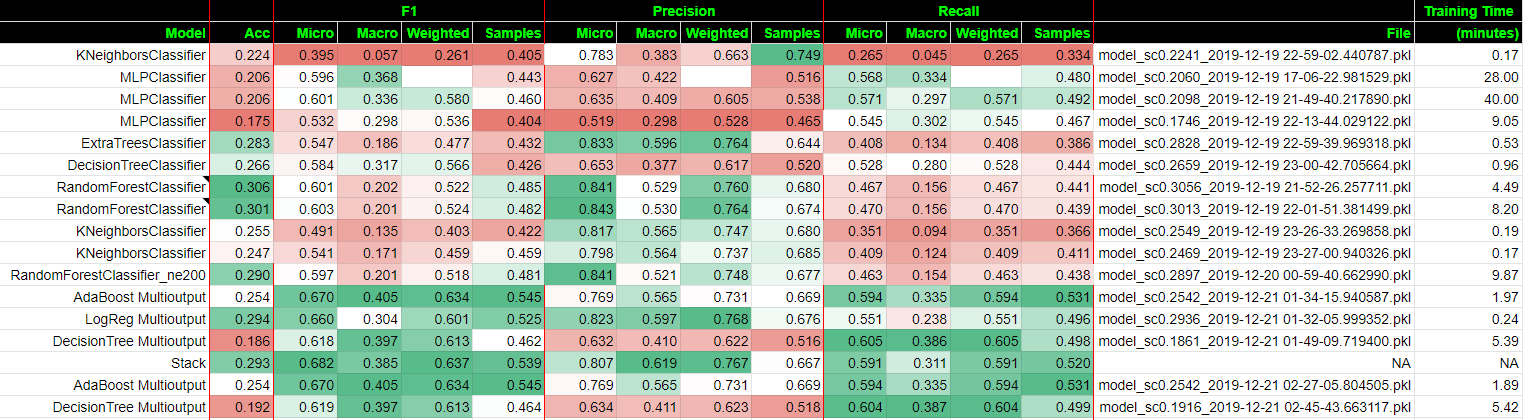

In [17]:
# Parameters for grid search

#parameters = {#Logistic Regression
#    'clf__estimator__C':[0.9, 1.0, 100, 1000, 5000],
#    'clf__estimator__max_iter':[100, 250, 500],
#    'clf__estimator__solver':['liblinear', 'saga'],
#    'clf__estimator__penalty':['l1', 'l2'],
#    'clf__estimator__multi_class':['auto'],
#}
#parameters = { #Logistic Regression
#    'clf__estimator__C':[1.0, .95, .9, .8],
#    'clf__estimator__max_iter':[100, 300],
#    'clf__estimator__solver':['newton-cg', 'sag', 'saga', 'lbfgs'],
#    'clf__estimator__penalty':['l2', 'none'],
#    'clf__estimator__multi_class':['ovr', 'multinomial'],
#}

#parameters = { # RandomForest
#    'clf__n_estimators':[1],
#    'clf__max_depth':[1],
#}

#parameters = { # AdaBoost
#    'clf__estimator__n_estimators':[5],
#    'clf__estimator__learning_rate' : [1.1],
#    'clf__estimator__base_estimator': [DecisionTreeClassifier(max_depth=1)]
#}

parameters = { # AdaBoost
    'clf__estimator__n_estimators':[50,60,70],
    'clf__estimator__learning_rate' : [0.98, 1.0, 1.1]
}

##### 6.3. Train, test and save Grid Search
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [18]:
def train_grid_search(pipeline_function, clf, parameters):
    
    with active_session():
            
        pipeline = pipeline_function(clf)

        cv = GridSearchCV(pipeline, parameters, cv=5, scoring='f1_micro', n_jobs=-1)

        t0 = datetime.now()
        print("Training started:", t0)
        cv.fit(X_train, y_train)

        print("Training time:", datetime.now() - t0)

        # Predict
        y_pred = cv.predict(X_test)

        # Evaluate and save
        f1 = evaluate_overall_results(y_test, y_pred)
        save_model(model=cv, score=f1)
        save_parameters(parameters=parameters, score=f1)
        evaluate_model_classes(y_test, y_pred, categories)


In [19]:
clf = MultiOutputClassifier(AdaBoostClassifier())
print(flat_pipeline(clf).get_params())

{'memory': None, 'steps': [('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_word at 0x7f47dac14a60>,
        vocabulary=None)), ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)), ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1))], 'counts': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor

In [20]:
# Call the training function
train_grid_search(pipeline_function=flat_pipeline, clf=clf, parameters=parameters)

Training started: 2019-12-23 17:30:10.412684
Training time: 1:25:38.539483


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.254   0.673   0.408   0.637   0.544   0.768   0.559   0.728   0.662   0.599   0.339   0.599   0.532   
Saving file: model_f1_0.6727_2019-12-23 18-55-54.720530.pkl
Saving file: grid-parameters_f1_0.6727_2019-12-23 18-55-54.915969.pkl
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.884      0.809      0.974      0.804
                  request      0.622      0.773      0.520      0.890
                    offer      0.000      0.000      0.000      0.995
              aid_related      0.709      0.773      0.654      0.776
             medical_help      0.377      0.592      0.276      0.930
         medical_products      0.404      0.579      

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [21]:
class SpecificStarting(BaseEstimator, TransformerMixin):
    
    def __init__(self, starting):
        self.starting = starting

    def check_starting(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag.startswith(self.starting):
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.check_starting)
        return pd.DataFrame(X_tagged)


In [22]:
classifiers = [ MultiOutputClassifier(AdaBoostClassifier()) ]

def union_pipeline(clf): # It doesn't add much to the scores
    return Pipeline([
        ('feat_extract', FeatureUnion([

            ('term_freq', Pipeline([
                ('counts', CountVectorizer(tokenizer=tokenize_word)),
                ('tfidf', TfidfTransformer())
            ])),
            ('starting_verb', SpecificStarting('VB')),# Verb
            ('starting_exist', SpecificStarting('EX')),# Existential
            ('starting_poss', SpecificStarting('PRP$')),# Possessive pronoun
            ('starting_inter', SpecificStarting('UH')),# Interjection
        ])),

        ('clf', clf)
    ])

In [23]:
train_classifiers(union_pipeline, classifiers) 

Training started: 2019-12-23 18:55:55.166711 
Training MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1)
Training time: 0:04:14.178344
Classifier : MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
           n_jobs=1)


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


|Accuracy  |              F1               |           Precision           |            Recall             |
           |Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples|Micro   Macro   Weight  Samples
    0.254   0.67    0.407   0.634   0.546   0.769   0.567   0.732   0.67    0.594   0.336   0.594   0.531   
Saving file: model_f1_0.6704_2019-12-23 19-01-06.376864.pkl
                 Category         F1  Precision     Recall   Accuracy
----------------------------------------------------------------------
                  related      0.883      0.804      0.979      0.800
                  request      0.609      0.766      0.506      0.887
                    offer      0.000      0.000      0.000      0.994
              aid_related      0.702      0.775      0.641      0.773
             medical_help      0.371      0.595      0.270      0.930
         medical_products      0.405      0.582      0.310      0.955
        search_and_rescue      0.308      0.631      

['model_f1_0.6704_2019-12-23 19-01-06.376864.pkl']